<a href="https://colab.research.google.com/github/CUOTR/Credit_Rating_Performance_Python_Project/blob/main/Credit_Rating_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PYTHON: CREDIT RATING PERFORMANCE**

# **Overview**

This project analyzes a  consumer loan dataset from KAGGLE  to evaluate the performance of the internal credit rating system (`sub_grade`).

The main objective is to assess whether the rating grades (from A1 to G5) effectively discriminate credit risk by examining actual

(`default rates`)(Charged Off loans) across different grades.

# I. EXTRACT, TRANSFORM, LOAD (ETL)


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/CREDIT_RATING.csv")

print(df.isnull().sum())
print(df.describe())
print(df.info())

id                        0
address_state             0
emp_length                0
emp_title              1087
home_ownership            0
loan_status               0
member_id                 0
purpose                   0
sub_grade                 0
term                      0
verification_status       0
annual_income             0
dti                       0
installment               0
int_rate                  0
loan_amount               0
total_acc                 0
total_payment             0
dtype: int64
                 id     member_id  annual_income           dti   installment  \
count  3.196300e+04  3.196300e+04   3.196300e+04  31963.000000  31963.000000   
mean   7.337336e+05  9.201666e+05   7.012571e+04      0.135312    329.247058   
std    1.858260e+05  2.211054e+05   6.488187e+04      0.066511    210.883700   
min    5.724500e+04  7.069900e+04   4.080000e+03      0.000000     16.250000   
25%    5.843730e+05  7.504905e+05   4.200000e+04      0.084400    169.780000   
50%

In [146]:
cols = ['annual_income', 'dti', 'loan_amount', 'installment']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print(":", len(df))

df_clean = df.copy()
for col in cols:
    df_clean = remove_outliers(df_clean, col)

print("Số khoản vay sau khi loại outlier:", len(df_clean))
print("Đã loại bỏ:", len(df) - len(df_clean), "khoản vay nghi là outlier")

df = df_clean

: 31963
Số khoản vay sau khi loại outlier: 28817
Đã loại bỏ: 3146 khoản vay nghi là outlier


In [147]:
df.drop(columns=['emp_title'], inplace=True)

df['loan_term'] = df['term'].str.extract(r'(\d+)').astype(float).astype(int)

df['grade'] = df['sub_grade'].str[0]

df.drop(columns=['term'], inplace=True)
df.head(1)

,id,address_state,emp_length,home_ownership,loan_status,member_id,purpose,sub_grade,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment,loan_term,grade
0,1068350,IL,10+ years,MORTGAGE,Fully Paid,1302971,car,A1,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835,36,A


In [148]:
import pandas as pd
import numpy as np
from scipy.optimize import newton

# (Giả sử df đã có dữ liệu 1 dòng như bạn cung cấp)

# Bước 1-2: Xây dựng cashflows (giữ nguyên)
df['num_full'] = (df['total_payment'] // df['installment']).astype(int)
df['partial'] = df['total_payment'] - df['num_full'] * df['installment']

df['cashflows'] = df.apply(
    lambda row: [-row['loan_amount']]
                + [row['installment']] * row['num_full']
                + ([row['partial']] if row['partial'] > 0 else []),
    axis=1
)

# Bước 3: Hàm NPV cải thiện (dùng numpy để nhanh hơn, tránh overflow)
def npv(rate, cashflows):
    if rate == -1:
        return np.sum(cashflows[1:])  # Tránh chia cho 0 nếu rate = -1
    periods = np.arange(len(cashflows))
    return np.sum(np.array(cashflows) / (1 + rate) ** periods)

# Bước 4: Tính IRR tháng với guess tốt hơn và xử lý lỗi
def calculate_irr(cashflows):
    if len(cashflows) < 2 or not any(cf > 0 for cf in cashflows) or not any(cf < 0 for cf in cashflows):
        return np.nan
    try:
        # Guess 0.005 (khoảng 6%/năm) thay vì 0.0 → hội tụ nhanh và ổn định
        return newton(lambda r: npv(r, cashflows), 0.005, tol=1e-6, maxiter=100)
    except RuntimeError:
        # Nếu vẫn lỗi (hiếm), thử guess khác
        try:
            return newton(lambda r: npv(r, cashflows), 0.0)
        except:
            return np.nan

df['irr_monthly'] = df['cashflows'].apply(calculate_irr)

# Bước 5: Tính IRR năm và thay đổi
df['irr_annual'] = (1 + df['irr_monthly']) ** 12 - 1
df['irr_annual_pct'] = df['irr_annual'] * 100
df['change_vs_initial_pct'] = (df['irr_annual'] - df['int_rate']) * 100

# Xem kết quả
print(df[['loan_amount', 'int_rate', 'total_payment', 'irr_annual_pct', 'change_vs_initial_pct']])

/tmp/ipython-input-225086013.py:23: RuntimeWarning: overflow encountered in power
  return np.sum(np.array(cashflows) / (1 + rate) ** periods)


       loan_amount  int_rate  total_payment  irr_annual_pct  \
0             3500    0.0603           3835        6.201878   
1             4800    0.0705           3210      -33.170263   
2             8000    0.0542           8686        5.556484   
3             3000    0.0542           3014        0.326373   
4             8000    0.0603           8765        6.196411   
...            ...       ...            ...             ...   
31953        16000    0.2359          20665       14.865660   
31954         4700    0.2159           7030       20.518233   
31957        24000    0.2114          39070       23.313496   
31960         6200    0.2159           3053      -67.208993   
31961        25000    0.2159          12809      -52.572363   

       change_vs_initial_pct  
0                   0.171878  
1                 -40.220263  
2                   0.136484  
3                  -5.093627  
4                   0.166411  
...                      ...  
31953              -8.7243

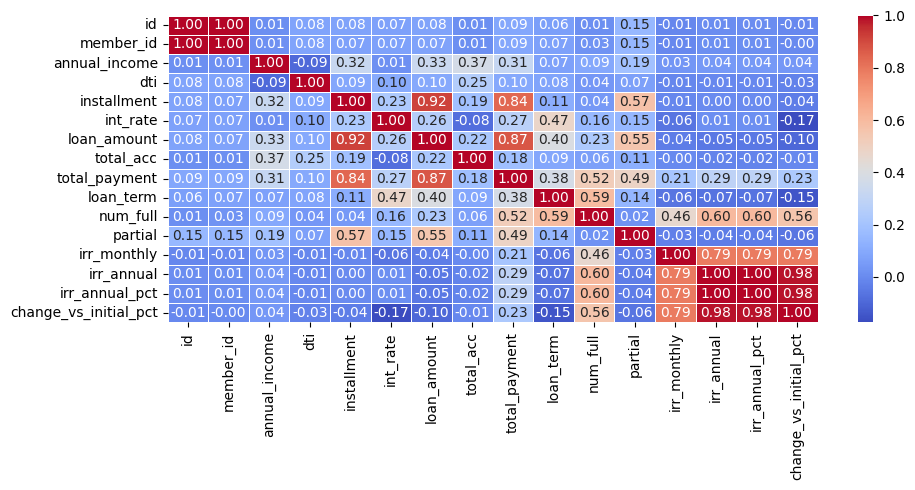

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.show()


# II. EXPLORATORY DATA ANALYSIS (EDA)

1. DEFAULT LOANS

In [150]:
df['is_default'] = df['loan_status'] == 'Charged Off'

total_loans = len(df)
default_loans = df['is_default'].sum()
default_rate = default_loans / total_loans * 100

print(f"TOTAL LOAN: {total_loans}")
print(f"DEFAULT LOANS: {default_loans}")
print(f"DEFAULT RATE: {default_rate:.2f}%")
print(df['loan_status'].value_counts())

TOTAL LOAN: 28817
DEFAULT LOANS: 4008
DEFAULT RATE: 13.91%
loan_status
Fully Paid     23899
Charged Off     4008
Current          910
Name: count, dtype: int64


In [163]:
df.groupby('loan_status')[['annual_income', 'dti', 'int_rate', 'loan_amount']].mean().round(4)

,annual_income,dti,int_rate,loan_amount
loan_status,,,,
Charged Off,55731.1096,0.1427,0.1376,10970.8957
Current,64082.0753,0.1514,0.1487,14737.2527
Fully Paid,61550.0140,0.1351,0.1143,9918.5960


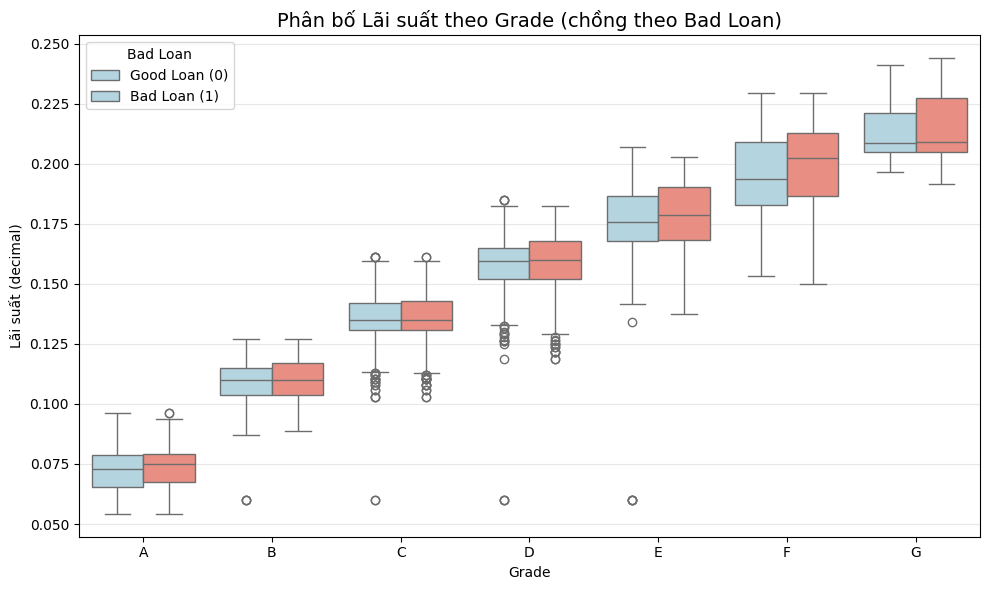

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Boxplot chồng theo bad_loan (hue)
sns.boxplot(x='grade', y='int_rate', data=df, hue='is_default',
            palette={0: 'lightblue', 1: 'salmon'},  # Màu cho good/bad
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

plt.title('Phân bố Lãi suất theo Grade (chồng theo Bad Loan)', fontsize=14)
plt.xlabel('Grade')
plt.ylabel('Lãi suất (decimal)')
plt.legend(title='Bad Loan', labels=['Good Loan (0)', 'Bad Loan (1)'], loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

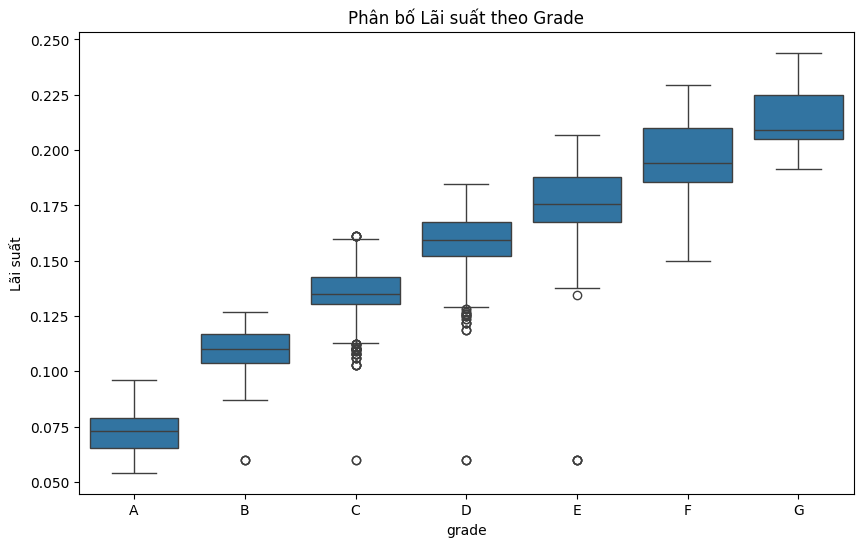

In [152]:
plt.figure(figsize=(10,6))
sns.boxplot(x='grade', y='int_rate', data=df)
plt.title('Phân bố Lãi suất theo Grade')
plt.ylabel('Lãi suất')
plt.show()

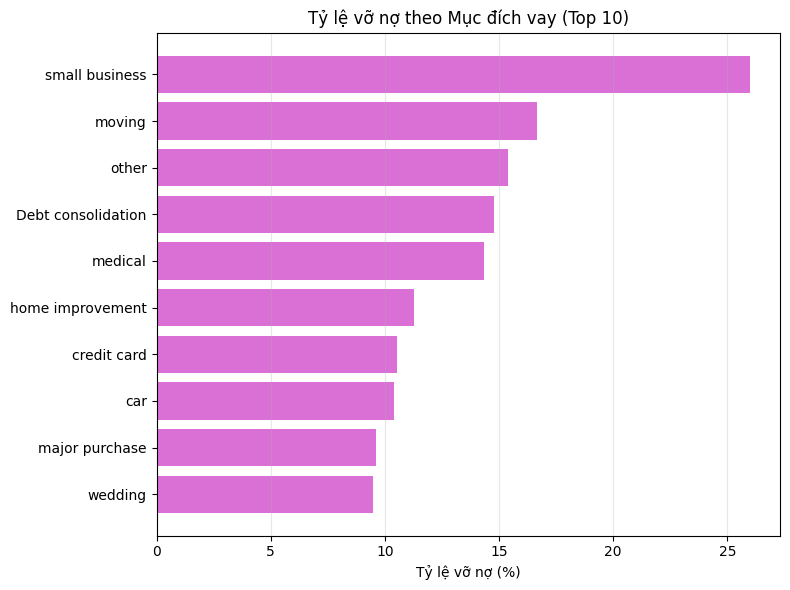

In [153]:
top10 = df['purpose'].value_counts().head(10).index
data = df[df['purpose'].isin(top10)]

default_rate = data.groupby('purpose')['is_default'].mean() * 100
default_rate = default_rate.sort_values(ascending=True)

plt.figure(figsize=(8,6))
plt.barh(default_rate.index, default_rate.values, color='orchid')
plt.title('Tỷ lệ vỡ nợ theo Mục đích vay (Top 10)')
plt.xlabel('Tỷ lệ vỡ nợ (%)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

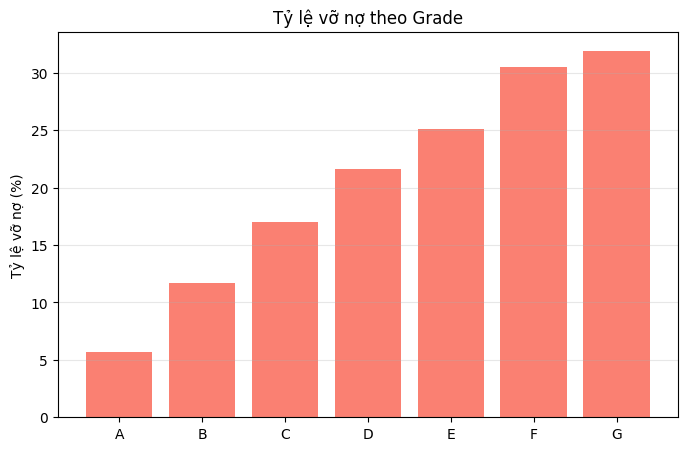

In [154]:
default_by_grade = df.groupby('grade')['is_default'].mean()*100

plt.figure(figsize=(8,5))
plt.bar(default_by_grade.index, default_by_grade.values, color='salmon')
plt.title('Tỷ lệ vỡ nợ theo Grade')
plt.ylabel('Tỷ lệ vỡ nợ (%)')
plt.grid(axis='y', alpha=0.3)
plt.show()

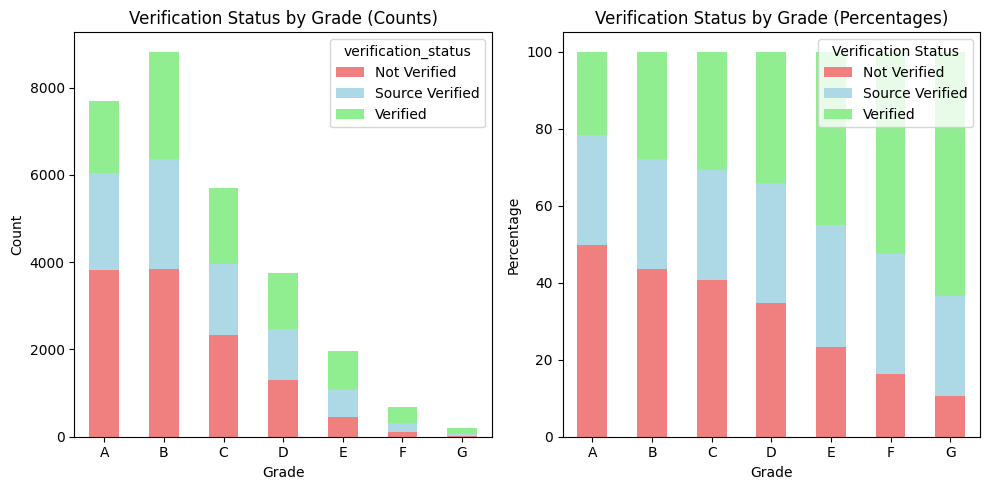

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

count = df.groupby(['grade', 'verification_status']).size().unstack(fill_value=0)

percent = count.div(count.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
colors = ['lightcoral', 'lightblue', 'lightgreen']

count.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
axes[0].set_title('Verification Status by Grade (Counts)')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

percent.plot(kind='bar', stacked=True, color=colors, ax=axes[1])
axes[1].set_title('Verification Status by Grade (Percentages)')
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Verification Status')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

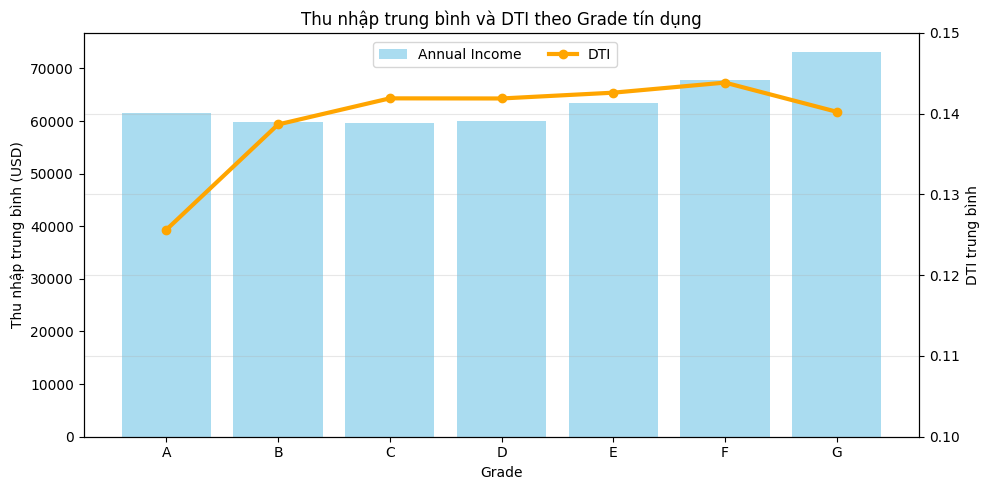

In [156]:
summary = df.groupby('grade')[['annual_income', 'dti']].mean()


fig, ax1 = plt.subplots(figsize=(10, 5))


ax1.bar(summary.index, summary['annual_income'], color='skyblue', alpha=0.7, label='Annual Income')
ax1.set_ylabel('Thu nhập trung bình (USD)')
ax1.set_xlabel('Grade')

ax2 = ax1.twinx()
ax2.plot(summary.index, summary['dti'], color='orange', marker='o', linewidth=3, label='DTI')
ax2.set_ylabel('DTI trung bình')
ax2.set_ylim(0.1, 0.15)

plt.title('Thu nhập trung bình và DTI theo Grade tín dụng')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

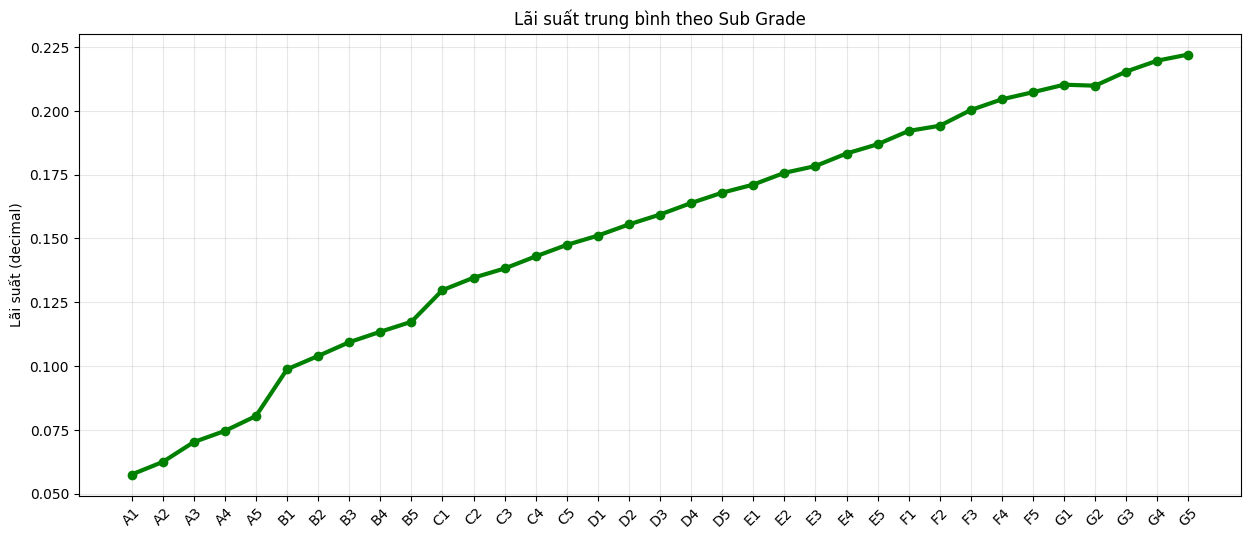

In [157]:
int_sub = df.groupby('sub_grade')['int_rate'].mean()

plt.figure(figsize=(15,6))
plt.plot(int_sub.index, int_sub.values, marker='o', color='green', linewidth=3)
plt.title('Lãi suất trung bình theo Sub Grade')
plt.ylabel('Lãi suất (decimal)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

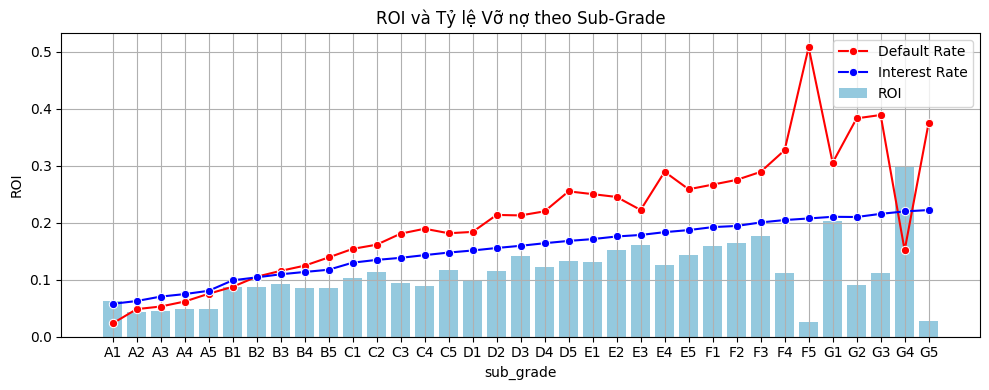

In [158]:
df['ROI'] = (df['total_payment'] / df['loan_amount']) - 1

summary = df.groupby('sub_grade').agg({
    'int_rate': 'mean',
    'ROI': 'mean',
    'is_default': 'mean',
    'installment': 'mean',
    'annual_income': 'mean',
    'loan_amount': 'mean',
    'total_payment': 'mean'
}).reset_index()

ROI_df = summary.sort_values(by='sub_grade')
ROI_df['Efficiency_Score'] = ROI_df['ROI'] / ROI_df['int_rate']

plt.figure(figsize=(10, 4))
ax1 = sns.barplot(data=ROI_df, x='sub_grade', y='ROI', color='skyblue', label='ROI')
ax2 = sns.lineplot(data=ROI_df, x='sub_grade', y='is_default', color='red', marker='o', label='Default Rate')
sns.lineplot(data=ROI_df, x='sub_grade', y='int_rate', color='blue', marker='o', label='Interest Rate')
plt.title('ROI và Tỷ lệ Vỡ nợ theo Sub-Grade')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

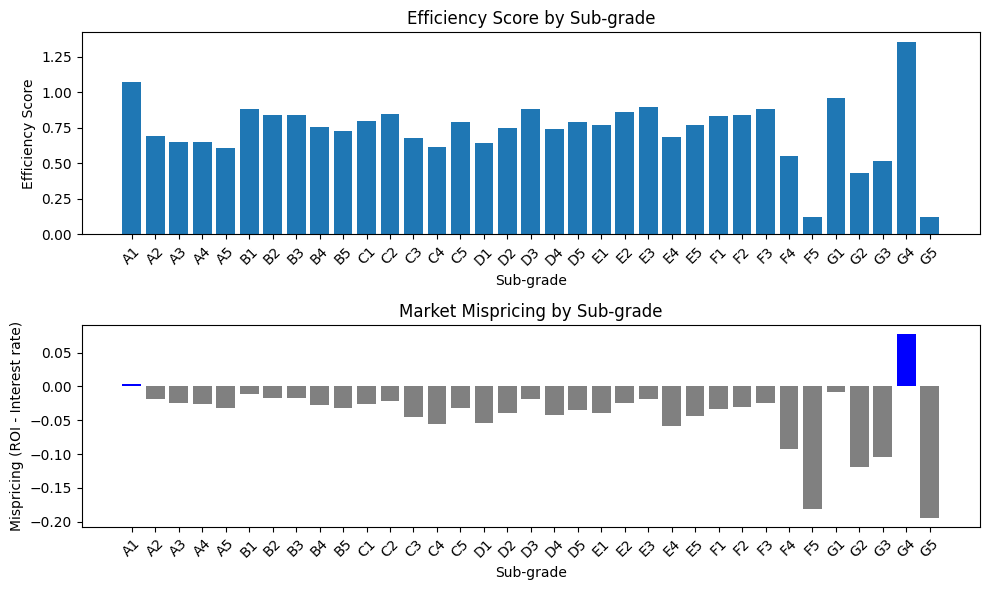

In [160]:
plt.figure(figsize=(10, 6))

# 2. Efficiency Score by Sub-grade
plt.subplot(2, 1, 1)
plt.bar(ROI_df['sub_grade'], ROI_df['Efficiency_Score'])
plt.title('Efficiency Score by Sub-grade')
plt.xlabel('Sub-grade')
plt.ylabel('Efficiency Score')
plt.xticks(rotation=45)

# 4. Market mispricing analysis - identify over/under performers
ROI_df['Mispricing'] = ROI_df['ROI'] - ROI_df['int_rate']

plt.subplot(2, 1, 2)
colors = ['grey' if x < 0 else 'blue' for x in ROI_df['Mispricing']]
plt.bar(ROI_df['sub_grade'], ROI_df['Mispricing'], color=colors)
plt.title('Market Mispricing by Sub-grade')
plt.xlabel('Sub-grade')
plt.ylabel('Mispricing (ROI - Interest rate)')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


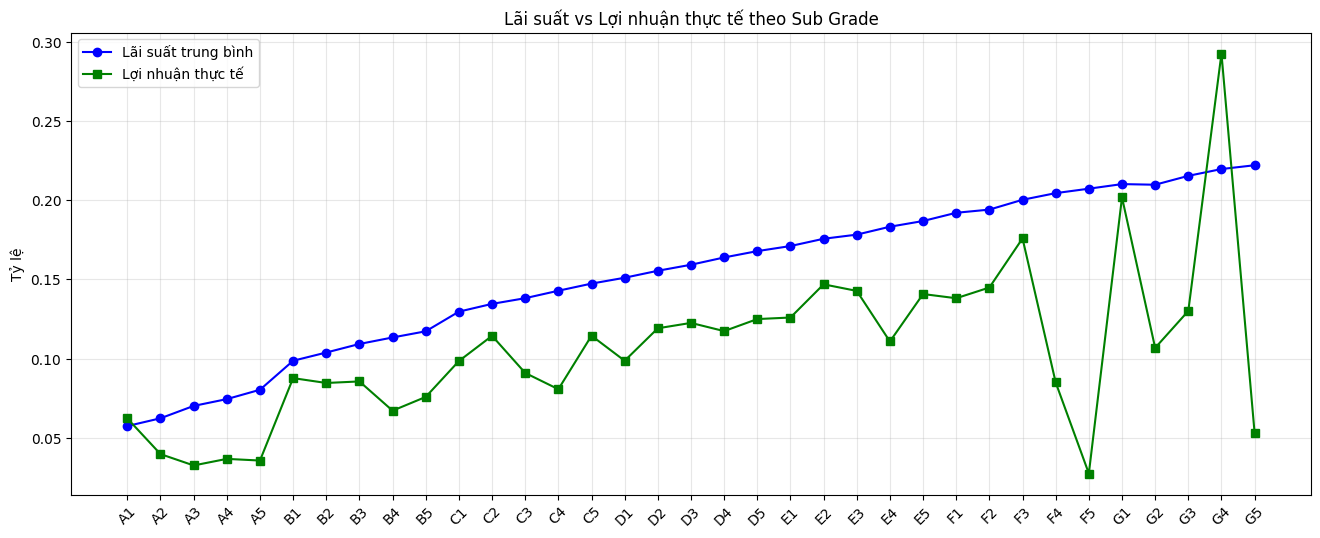

In [161]:
# Tạo biến và tính theo sub_grade
sub_summary = df.groupby('sub_grade').agg(
    avg_int_rate=('int_rate', 'mean'),
    default_rate=('is_default', 'mean'),
    avg_loan_amount=('loan_amount', 'mean'),
    avg_total_payment=('total_payment', 'mean'),
    count=('loan_amount', 'count')
).round(4)

sub_summary['actual_return_rate'] = (sub_summary['avg_total_payment'] / sub_summary['avg_loan_amount']) - 1
sub_summary['expected_net_rate'] = sub_summary['avg_int_rate'] - sub_summary['default_rate']
sub_summary['profitable'] = sub_summary['actual_return_rate'] > 0

# Sắp xếp đúng thứ tự
sub_summary = sub_summary.reset_index()
sub_summary['grade_order'] = sub_summary['sub_grade'].str[0].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
sub_summary['sub_order'] = sub_summary['sub_grade'].str[1:].astype(int)
sub_summary = sub_summary.sort_values(['grade_order', 'sub_order']).drop(['grade_order','sub_order'], axis=1)

# Biểu đồ so sánh
plt.figure(figsize=(16,6))
plt.plot(sub_summary['sub_grade'], sub_summary['avg_int_rate'], marker='o', label='Lãi suất trung bình', color='blue')
plt.plot(sub_summary['sub_grade'], sub_summary['actual_return_rate'], marker='s', label='Lợi nhuận thực tế', color='green')
plt.title('Lãi suất vs Lợi nhuận thực tế theo Sub Grade')
plt.ylabel('Tỷ lệ')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

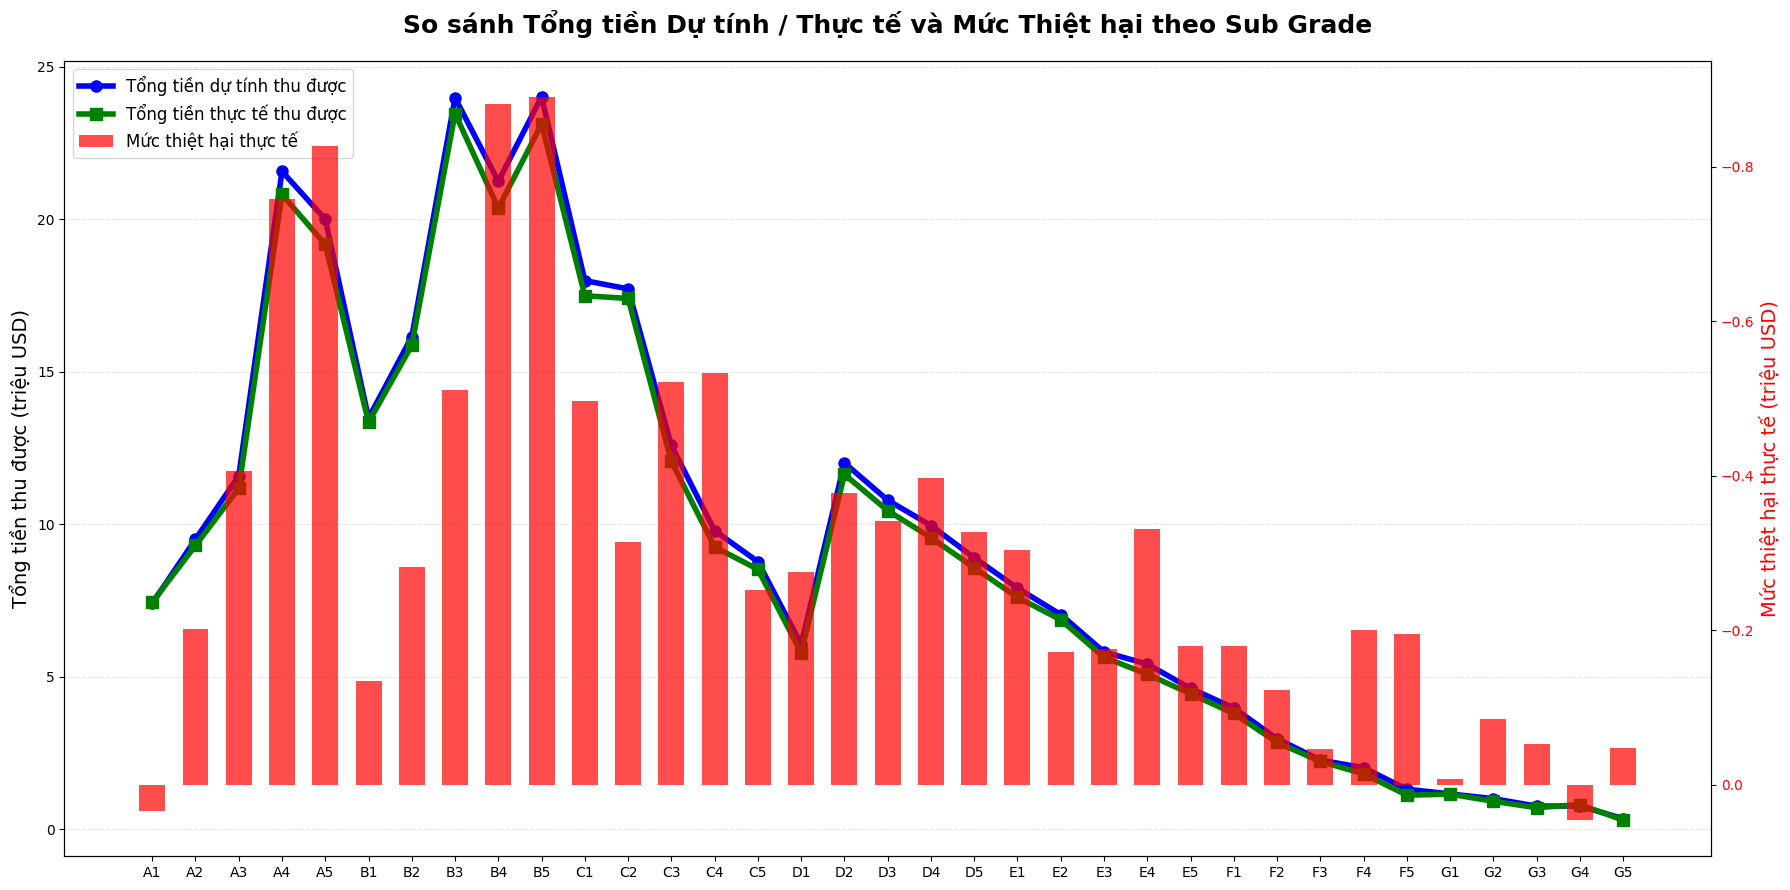

MỨC THIỆT HẠI THỰC TẾ THEO SUB GRADE (triệu USD)


,sub_grade,expected_total,total_payment,actual_loss
0,A1,7.41,7.44,-0.03
1,A2,9.51,9.31,0.20
2,A3,11.59,11.18,0.41
3,A4,21.58,20.82,0.76
4,A5,20.01,19.18,0.83
5,B1,13.48,13.35,0.13
6,B2,16.15,15.87,0.28
7,B3,23.98,23.47,0.51
8,B4,21.25,20.37,0.88
9,B5,24.02,23.13,0.89


In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Tính tổng theo sub_grade
sub_summary = df.groupby('sub_grade').agg(
    total_loan_amount=('loan_amount', 'sum'),
    total_payment=('total_payment', 'sum'),
    avg_int_rate=('int_rate', 'mean')
).reset_index()

# Tổng tiền dự tính: loan_amount * (1 + lãi suất trung bình)
sub_summary['expected_total'] = sub_summary['total_loan_amount'] * (1 + sub_summary['avg_int_rate'])

# Mức thiệt hại thực tế (dự tính - thực tế)
sub_summary['actual_loss'] = sub_summary['expected_total'] - sub_summary['total_payment']

# Sắp xếp đúng thứ tự A1 → G5
sub_summary['grade_order'] = sub_summary['sub_grade'].str[0].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
sub_summary['sub_order'] = sub_summary['sub_grade'].str[1:].astype(int)
sub_summary = sub_summary.sort_values(['grade_order', 'sub_order']).reset_index(drop=True)

# Vẽ biểu đồ kết hợp: 2 trục trên + cột dưới
fig, ax1 = plt.subplots(figsize=(18, 9))

# Phần trên: 2 đường - Dự tính và Thực tế (trục chính)
ax1.plot(sub_summary['sub_grade'], sub_summary['expected_total'] / 1_000_000,
         marker='o', linewidth=4, markersize=8, label='Tổng tiền dự tính thu được', color='blue')
ax1.plot(sub_summary['sub_grade'], sub_summary['total_payment'] / 1_000_000,
         marker='s', linewidth=4, markersize=8, label='Tổng tiền thực tế thu được', color='green')
ax1.set_ylabel('Tổng tiền thu được (triệu USD)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('So sánh Tổng tiền Dự tính / Thực tế và Mức Thiệt hại theo Sub Grade',
              fontsize=18, fontweight='bold', pad=20)

# Phần dưới: Cột thiệt hại (trục phụ thứ hai - đảo chiều để nằm dưới)
ax2 = ax1.twinx()
ax2.bar(sub_summary['sub_grade'], -sub_summary['actual_loss'] / 1_000_000,
        color='red', alpha=0.7, label='Mức thiệt hại thực tế', width=0.6)
ax2.set_ylabel('Mức thiệt hại thực tế (triệu USD)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()  # Đảo trục để cột "mọc xuống dưới"

# Thêm legend
lines1, labels1 = ax1.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + bars, labels1 + labels2, loc='upper left', fontsize=12)

# Tùy chỉnh chung
plt.xticks(rotation=45, fontsize=12)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# In bảng tóm tắt thiệt hại
print("MỨC THIỆT HẠI THỰC TẾ THEO SUB GRADE (triệu USD)")
display(sub_summary[['sub_grade', 'expected_total', 'total_payment', 'actual_loss']]
        .assign(**{
            'expected_total': (sub_summary['expected_total']/1_000_000).round(2),
            'total_payment': (sub_summary['total_payment']/1_000_000).round(2),
            'actual_loss': (sub_summary['actual_loss']/1_000_000).round(2)
        }))